In [128]:
import pickle
import warnings
from math import sqrt

import lightgbm as lgb
import matplotlib as mpl
import numpy as np
import pandas as pd  # Basic library for all of our dataset operations
import pmdarima as pm
import xgboost as xgb
# from bayes_opt import BayesianOptimization
from prophet import Prophet
from matplotlib import pyplot as plt
from sklearn import linear_model, svm
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.ar_model import AR 
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from statsmodels.tsa.statespace.sarimax import SARIMAX
from tqdm import tqdm
from utils.metrics import evaluate



# We will use deprecated models of statmodels which throw a lot of warnings to use more modern ones
warnings.filterwarnings("ignore")


# Extra settings
seed = 42

np.random.seed(seed)
plt.style.use('bmh')
mpl.rcParams['axes.labelsize'] = 14
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['text.color'] = 'k'
mpl.rcParams['figure.figsize'] = 18, 8
mpl.rcParams['font.family'] = 'simsun'
# 设置负号显示
mpl.rcParams['axes.unicode_minus'] = False



## Prepare data before modeling

In [129]:

resultsDict = {}
predictionsDict = {}

data = pd.read_csv("data/op_data.csv",index_col=0)
import holidays

# 选择中国的节假日
chinese_holidays = holidays.China()
data["Date"] = pd.to_datetime(data.index)
data['IsHoliday'] = data['Date'].apply(lambda x: 1 if x in chinese_holidays else 0)
import lunardate
# 判断每一天是否为春节
def is_spring_festival(date):
    lunar_date = lunardate.LunarDate.fromSolarDate(date.year, date.month, date.day)
    if lunar_date.month == 1 and (lunar_date.day >= 1 and lunar_date.day <= 7):
        return 1
    if lunar_date.month == 12 and (lunar_date.day >= 24 and lunar_date.day <= 30):
        return 1
    return 0
# 设置农历腊月24 到正月初7为春节
data['IsSpringFestival'] = data['Date'].apply(is_spring_festival)
data.drop("Date",axis=1,inplace= True)


split_date = '2023-08-01'
df_training = data.loc[data.index < split_date]
df_test = data.loc[data.index >= split_date]
print(f"{len(df_training)} days of training data \n {len(df_test)} days of testing data ")

df_training.to_csv('data/training.csv')
df_test.to_csv('data/test.csv')

2037 days of training data 
 31 days of testing data 


### Simple Exponential Smoothing (SES)

In [32]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test["离职人数"]))):
    temp_train = data[:len(df_training)+t]
    model = SimpleExpSmoothing(temp_train["离职人数"])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SES'] = evaluate(df_test["离职人数"], yhat.values)
predictionsDict['SES'] = yhat.values

 84%|████████▍ | 26/31 [00:00<00:00, 94.63it/s]

100%|██████████| 31/31 [00:00<00:00, 86.32it/s]


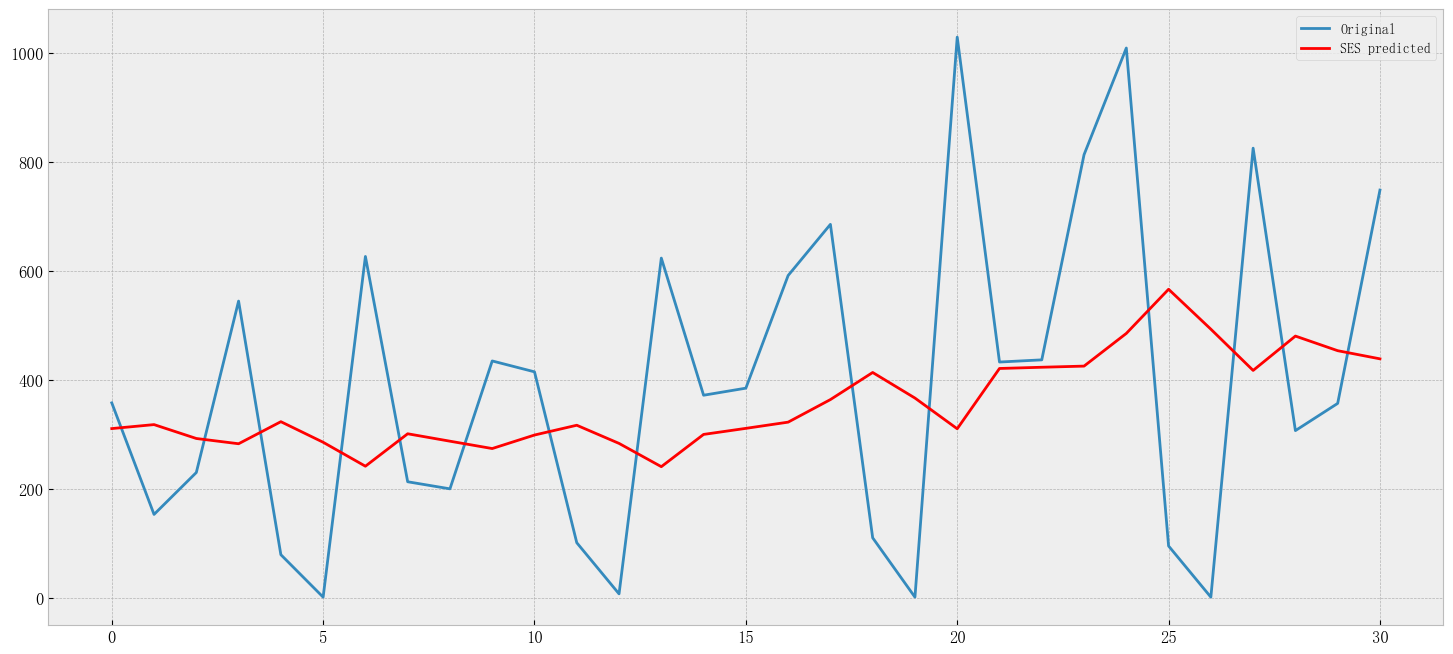

In [33]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat.values, color='red', label='SES predicted')
plt.legend()

### Holt Winter’s Exponential Smoothing (HWES)

In [34]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test["离职人数"]))):
    temp_train = data[:len(df_training)+t]
    model = ExponentialSmoothing(temp_train["离职人数"])
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train))
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['HWES'] = evaluate(df_test["离职人数"], yhat.values)
predictionsDict['HWES'] = yhat.values

100%|██████████| 31/31 [00:00<00:00, 71.36it/s]


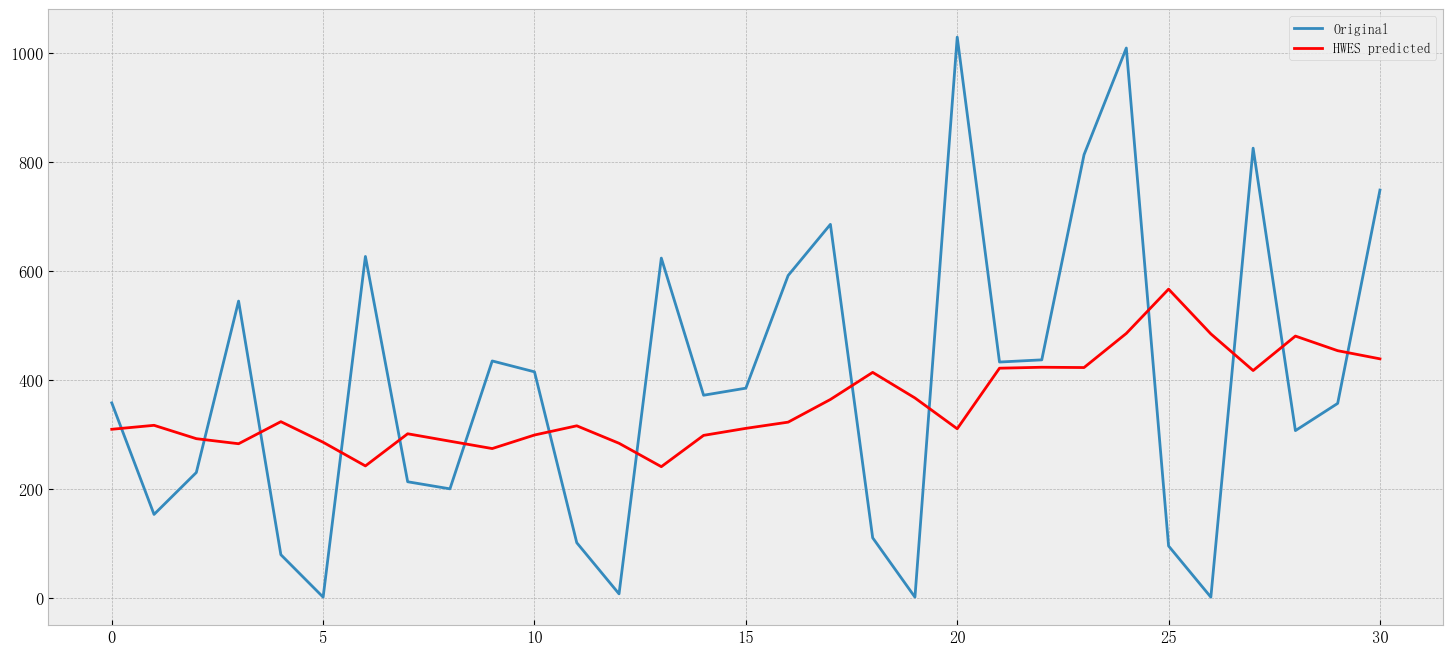

In [35]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat.values, color='red', label='HWES predicted')
plt.legend()

### Autoregression (AR)


In [36]:
# Walk throught the test data, training and predicting 1 day ahead for all the test data
from statsmodels.tsa.ar_model import AutoReg
index = len(df_training)
yhat = list()
for t in tqdm(range(len(df_test["离职人数"]))):
    temp_train = data[:len(df_training)+t]
    model = AutoReg(temp_train["离职人数"], lags=1)
    model_fit = model.fit()
    predictions = model_fit.predict(start=len(temp_train), end=len(temp_train),dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AR'] = evaluate(df_test["离职人数"], yhat.values)
predictionsDict['AR'] = yhat.values

100%|██████████| 31/31 [00:00<00:00, 129.39it/s]


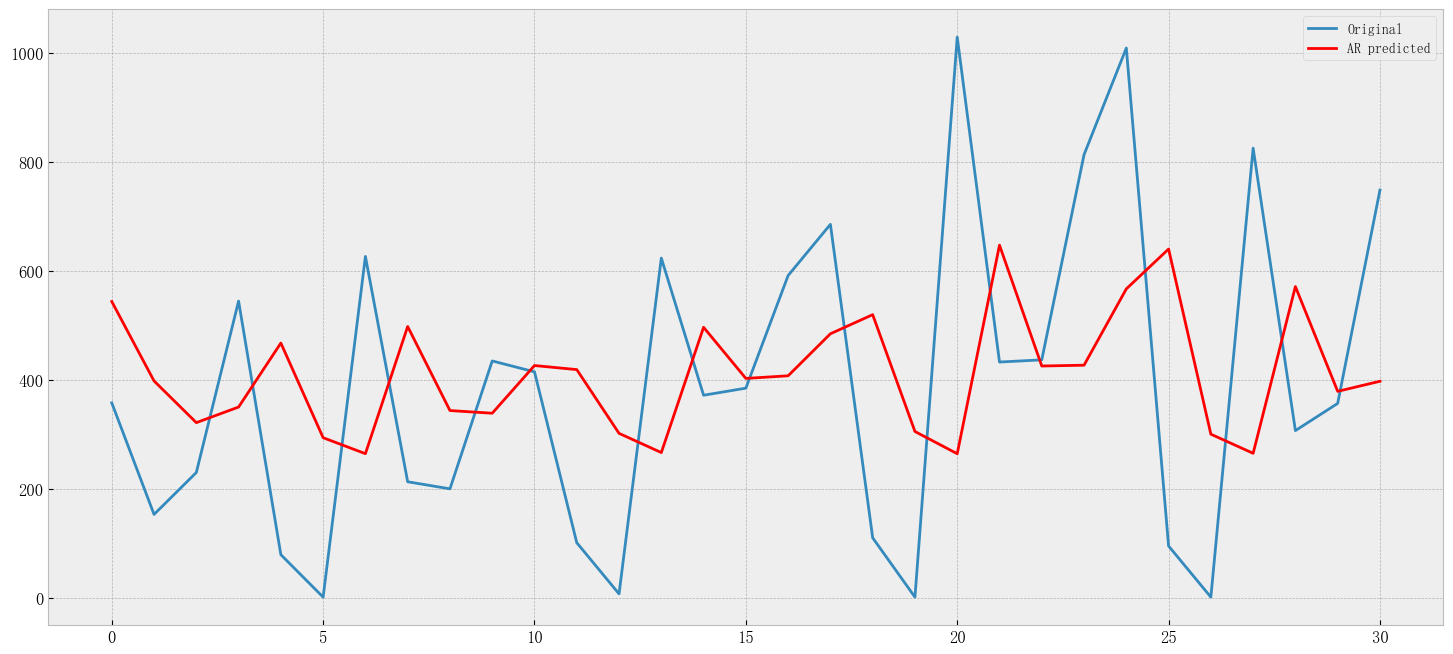

In [37]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat.values, color='red', label='AR predicted')
plt.legend()

### Auto ARIMA

In [38]:
# MA example
autoModel = pm.auto_arima(df_training["离职人数"], trace=True,start_p=0, d=0,start_q=0, max_p=4,max_d=4,max_q=4,
                         start_P=0, D=1, start_Q=0, max_P=4, max_D=4, max_Q=4,m=3,
                          error_action='ignore', suppress_warnings=True, seasonal=True)
autoModel.fit(df_training["离职人数"])


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=31378.372, Time=0.36 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=30835.258, Time=1.20 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=1.27 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=31376.374, Time=0.04 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=31294.937, Time=0.13 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=30736.687, Time=1.75 sec
 ARIMA(1,0,0)(3,1,0)[3] intercept   : AIC=30657.556, Time=2.24 sec
 ARIMA(1,0,0)(4,1,0)[3] intercept   : AIC=30558.081, Time=3.14 sec
 ARIMA(1,0,0)(4,1,1)[3] intercept   : AIC=30566.858, Time=8.57 sec
 ARIMA(1,0,0)(3,1,1)[3] intercept   : AIC=30280.242, Time=6.76 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=4.94 sec
 ARIMA(1,0,0)(3,1,2)[3] intercept   : AIC=inf, Time=4.33 sec
 ARIMA(1,0,0)(2,1,2)[3] intercept   : AIC=inf, Time=3.54 sec
 ARIMA(1,0,0)(4,1,2)[3] intercept   : AIC=inf, Time=9.01 sec
 ARIMA(0,0,0)(3,1,1)[3] intercept   : AIC=30392.5

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(3, 1, 1, 3),
      suppress_warnings=True)

In [39]:

order = autoModel.order
yhat = list()
for t in tqdm(range(len(df_test["离职人数"]))):
    temp_train = data[:len(df_training)+t]
    model = ARIMA(temp_train["离职人数"], order=order)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoARIMA {0}'.format(order)] = evaluate(
    df_test["离职人数"], yhat)
predictionsDict['AutoARIMA {0}'.format(order)] = yhat.values

100%|██████████| 31/31 [00:06<00:00,  5.09it/s]


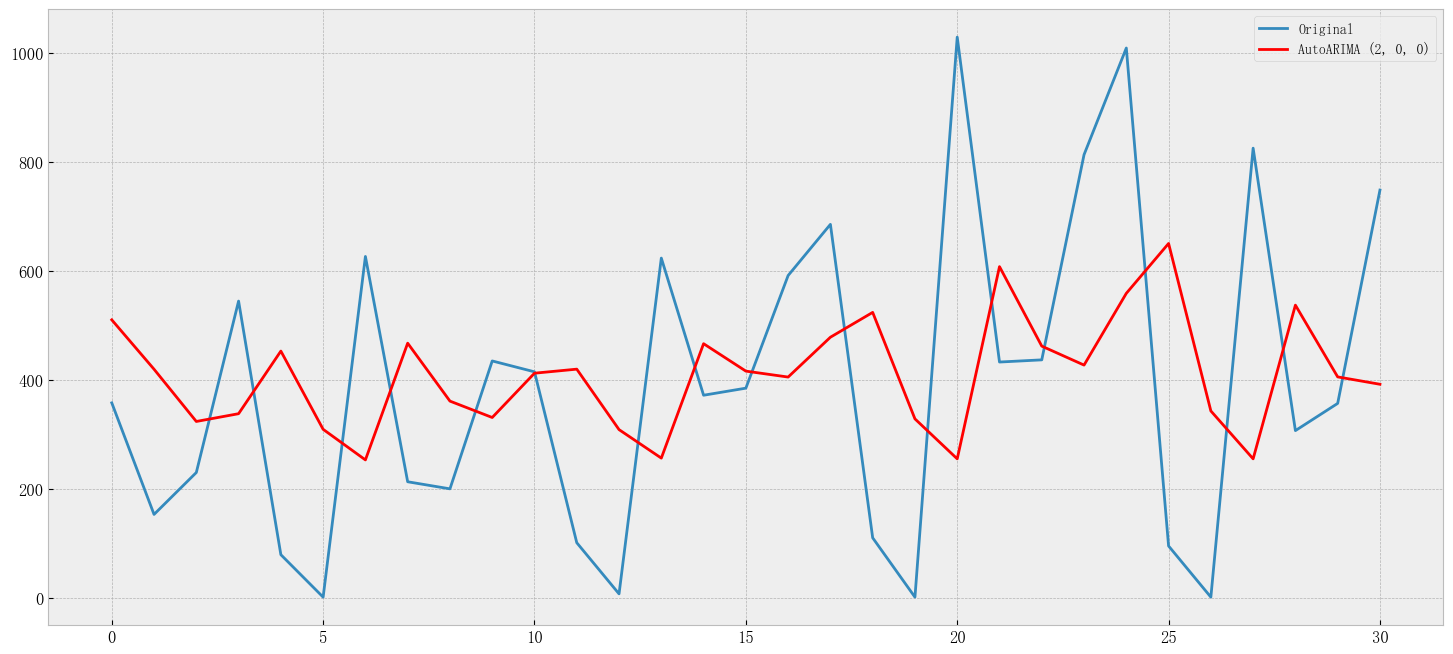

In [40]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat.values, color='red', label='AutoARIMA {0}'.format(order))
plt.legend()

###  SARIMA

In [41]:

yhat = list()
for t in tqdm(range(len(df_test["离职人数"]))):
    temp_train = data[:len(df_training)+t]
    model = SARIMAX(temp_train["离职人数"],order=(
        1, 0, 0), seasonal_order=(0, 0, 0, 3))
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['SARIMAX {0}'.format(order)] = evaluate(
    df_test["离职人数"], yhat)
predictionsDict['SARIMAX {0}'.format(order)] = yhat.values

  3%|▎         | 1/31 [00:00<00:03,  8.83it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54645D+00    |proj g|=  2.36065D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.042D-06   7.546D+00
  F =   7.5464463042185450     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 13%|█▎        | 4/31 [00:00<00:02,  9.12it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54599D+00    |proj g|=  2.35807D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.042D-06   7.546D+00
  F =   7.5459876862700943     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 This problem is unconstrained.
 19%|█▉        | 6/31 [00:00<00:02,  9.46it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54570D+00    |proj g|=  2.35585D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.041D-06   7.546D+00
  F =   7.5456955655741869     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 This problem is unconstrained.
 23%|██▎       | 7/31 [00:00<00:02,  9.54it/s] This problem is unconstrained.
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54530D+00    |proj g|=  2.35327D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.040D-06   7.545D+00
  F =   7.5453035814122495     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 29%|██▉       | 9/31 [00:00<00:01, 11.38it/s] This problem is unconstrained.
 This problem is unconstrained.
 35%|███▌      | 11/31 [00:01<00:01, 10.57it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54508D+00    |proj g|=  2.34964D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.039D-06   7.545D+00
  F =   7.5450809212932226     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 This problem is unconstrained.
 This problem is unconstrained.
 42%|████▏     | 13/31 [00:01<00:01, 10.18it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54472D+00    |proj g|=  2.34742D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.039D-06   7.545D+00
  F =   7.5447165186855392     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 This problem is unconstrained.
 This problem is unconstrained.
 48%|████▊     | 15/31 [00:01<00:01, 10.04it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54427D+00    |proj g|=  2.34496D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.038D-06   7.544D+00
  F =   7.5442687047152743     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 This problem is unconstrained.
 This problem is unconstrained.
 55%|█████▍    | 17/31 [00:01<00:01,  9.77it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54423D+00    |proj g|=  2.34263D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.037D-06   7.544D+00
  F =   7.5442305881575669     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 This problem is unconstrained.
 61%|██████▏   | 19/31 [00:01<00:01,  9.72it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54390D+00    |proj g|=  2.34051D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.036D-06   7.544D+00
  F =   7.5438959964841610     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 This problem is unconstrained.
 68%|██████▊   | 21/31 [00:02<00:01,  9.64it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54365D+00    |proj g|=  2.33810D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.035D-06   7.544D+00
  F =   7.5436487771836722     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 This problem is unconstrained.
 74%|███████▍  | 23/31 [00:02<00:00,  9.62it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54440D+00    |proj g|=  2.33594D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.034D-06   7.544D+00
  F =   7.5444010986684020     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 This problem is unconstrained.
 77%|███████▋  | 24/31 [00:02<00:00,  8.67it/s] This problem is unconstrained.


           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54402D+00    |proj g|=  2.33334D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.033D-06   7.544D+00
  F =   7.5440158634292809     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54409D+00    |proj g|=  2.33

 84%|████████▍ | 26/31 [00:02<00:00,  8.00it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54410D+00    |proj g|=  2.33182D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.032D-06   7.544D+00
  F =   7.5441000275974854     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 90%|█████████ | 28/31 [00:03<00:00,  7.78it/s] This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54401D+00    |proj g|=  2.32880D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.031D-06   7.544D+00
  F =   7.5440087501681043     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.5

 97%|█████████▋| 30/31 [00:03<00:00,  7.52it/s]


           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.030D-06   7.545D+00
  F =   7.5445555904872714     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54438D+00    |proj g|=  2.32634D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates

 This problem is unconstrained.
100%|██████████| 31/31 [00:03<00:00,  8.98it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            2     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.54417D+00    |proj g|=  2.32524D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    2      2      4      1     0     0   1.029D-06   7.544D+00
  F =   7.5441671366060969     

CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL            


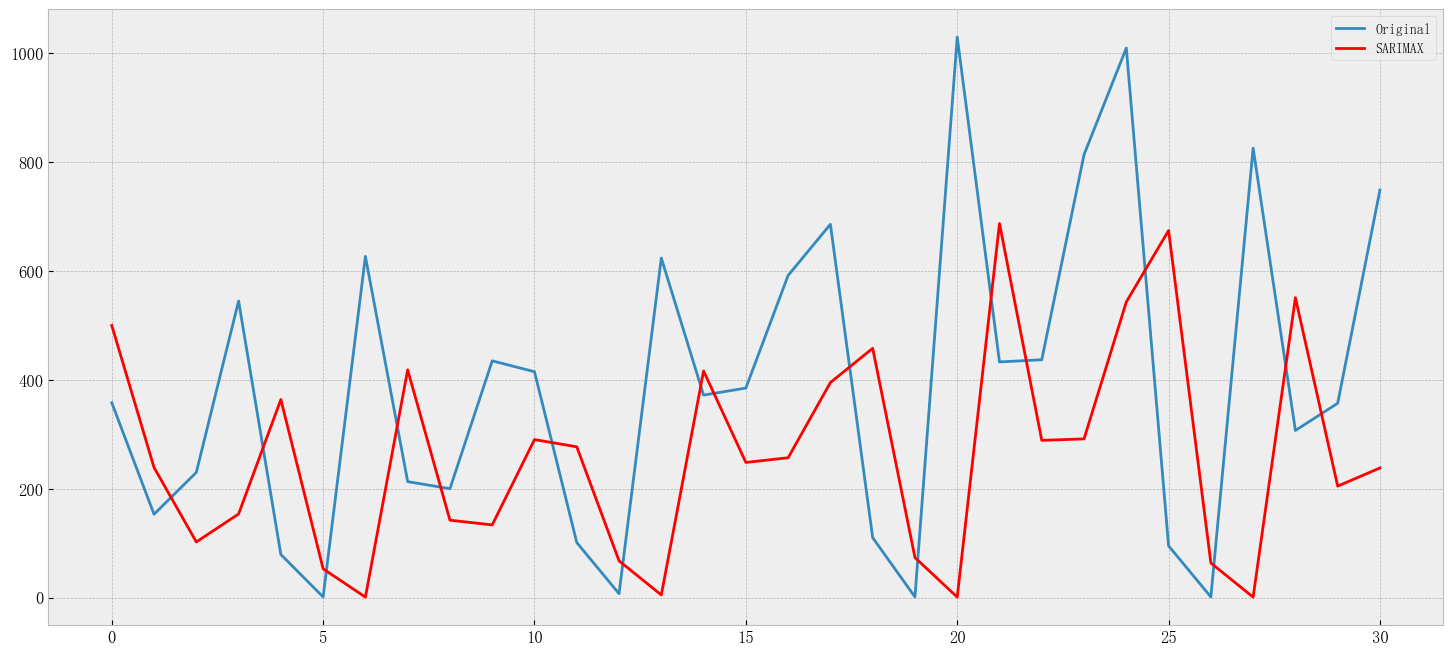

In [42]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

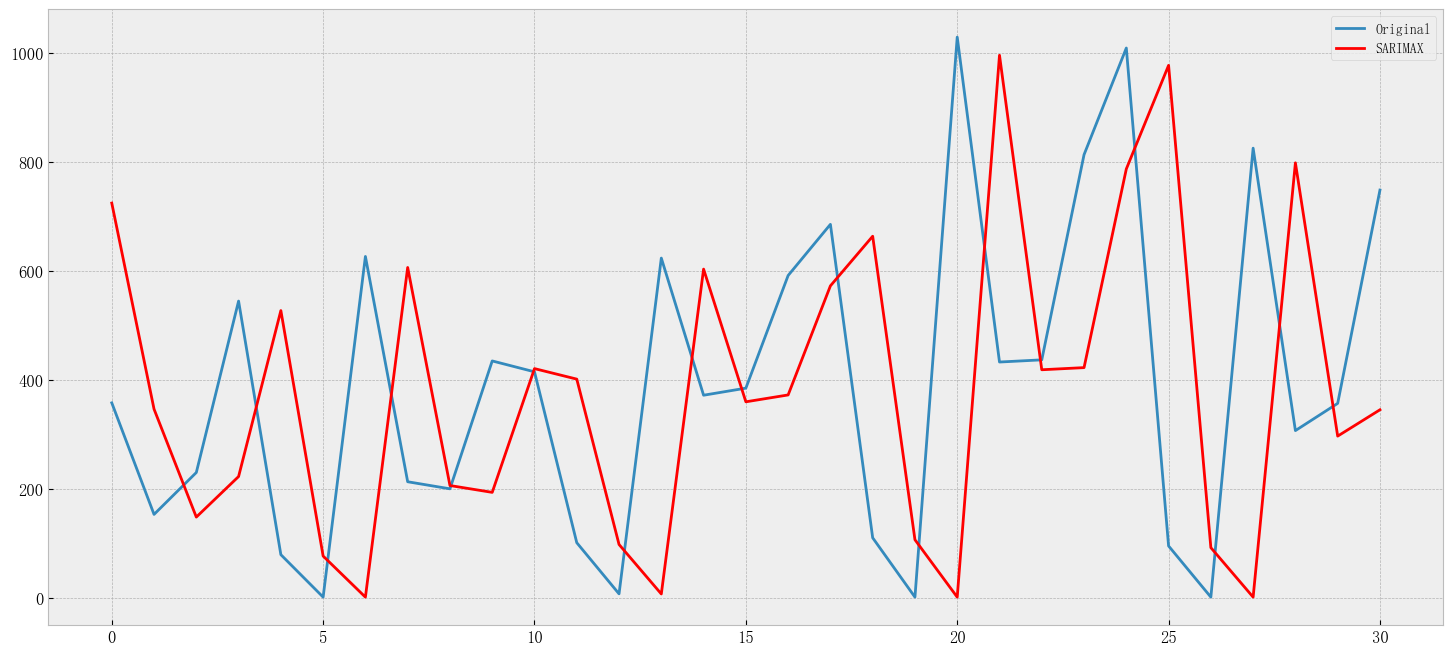

In [43]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat.values *1.45, color='red', label='SARIMAX')
plt.legend()

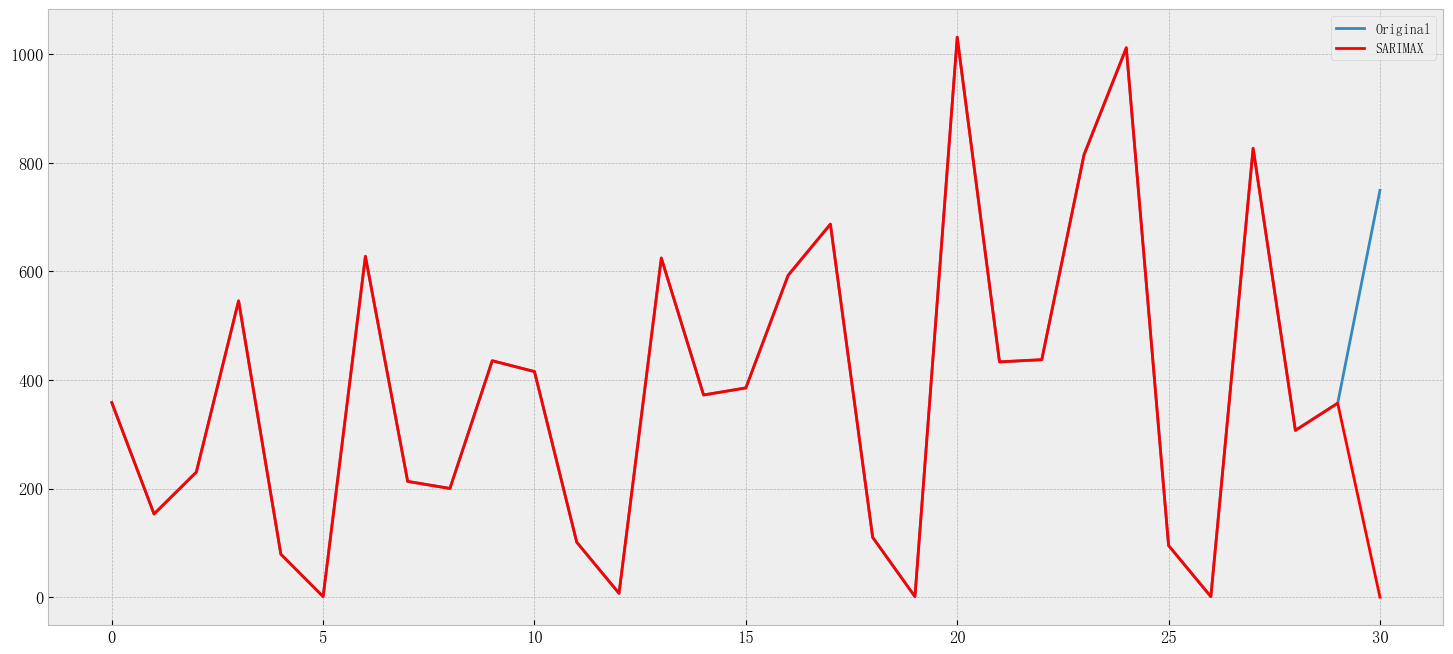

In [44]:

# 假设yhat是一个NumPy数组
yhat_shifted = np.roll(yhat.values, -1)
yhat_shifted[-1] = 0
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat_shifted *1.5, color='red', label='SARIMAX')
plt.legend()

### Auto - SARIMA

In [45]:
# building the model
autoModel = pm.auto_arima(df_training["离职人数"], trace=True, error_action='ignore',
                          suppress_warnings=True, seasonal=True,start_p=0, d=0,start_q=0, max_p=4,max_d=4,max_q=4,
                         start_P=0, D=1, start_Q=0, max_P=4, max_D=4, max_Q=4, m=3, stepwise=True)
autoModel.fit(df_training["离职人数"])

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,1,0)[3] intercept   : AIC=31378.372, Time=0.08 sec
 ARIMA(1,0,0)(1,1,0)[3] intercept   : AIC=30835.258, Time=1.31 sec
 ARIMA(0,0,1)(0,1,1)[3] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(0,0,0)(0,1,0)[3]             : AIC=31376.374, Time=0.05 sec
 ARIMA(1,0,0)(0,1,0)[3] intercept   : AIC=31294.937, Time=0.14 sec
 ARIMA(1,0,0)(2,1,0)[3] intercept   : AIC=30736.687, Time=1.62 sec
 ARIMA(1,0,0)(3,1,0)[3] intercept   : AIC=30657.556, Time=2.23 sec
 ARIMA(1,0,0)(4,1,0)[3] intercept   : AIC=30558.081, Time=2.97 sec
 ARIMA(1,0,0)(4,1,1)[3] intercept   : AIC=30566.858, Time=7.56 sec
 ARIMA(1,0,0)(3,1,1)[3] intercept   : AIC=30280.242, Time=5.96 sec
 ARIMA(1,0,0)(2,1,1)[3] intercept   : AIC=inf, Time=4.47 sec
 ARIMA(1,0,0)(3,1,2)[3] intercept   : AIC=inf, Time=4.01 sec
 ARIMA(1,0,0)(2,1,2)[3] intercept   : AIC=inf, Time=2.99 sec
 ARIMA(1,0,0)(4,1,2)[3] intercept   : AIC=inf, Time=8.48 sec
 ARIMA(0,0,0)(3,1,1)[3] intercept   : AIC=30392.5

ARIMA(order=(2, 0, 0), scoring_args={}, seasonal_order=(3, 1, 1, 3),
      suppress_warnings=True)

In [ ]:
order = autoModel.order
seasonalOrder = autoModel.seasonal_order
yhat = list()
for t in tqdm(range(len(df_test["离职人数"]))):
    temp_train = data[:len(df_training)+t]
    model = SARIMAX(temp_train["离职人数"], order=order,
                    seasonal_order=seasonalOrder)
    model_fit = model.fit()
    predictions = model_fit.predict(
        start=len(temp_train), end=len(temp_train), dynamic=False)
    yhat = yhat + [predictions]

yhat = pd.concat(yhat)
resultsDict['AutoSARIMAX {0},{1}'.format(order, seasonalOrder)] = evaluate(
    df_test["离职人数"], yhat.values)
predictionsDict['AutoSARIMAX {0},{1}'.format(
    order, seasonalOrder)] = yhat.values

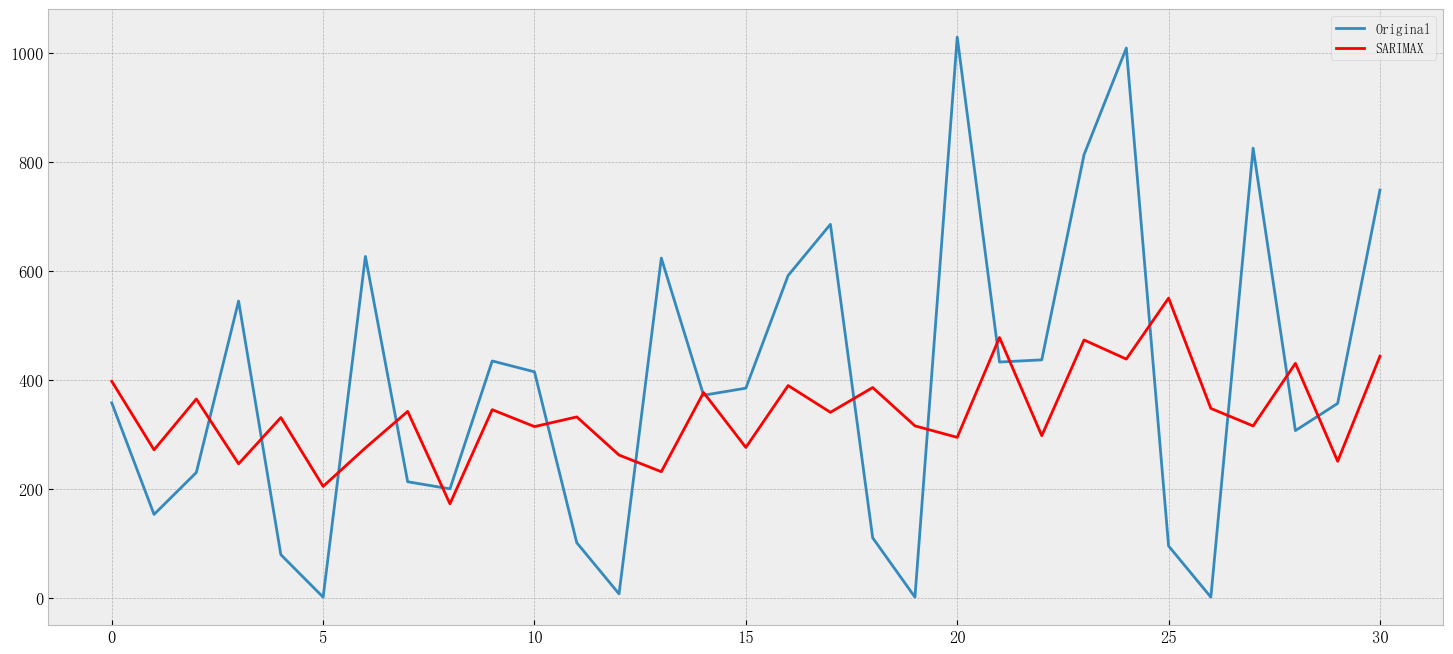

In [ ]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat.values, color='red', label='SARIMAX')
plt.legend()

### Prophet


In [47]:
# Prophet needs some specifics data stuff, coment it here
prophet_training = df_training.rename(
    columns={'离职人数': 'y'})  # old method
prophet_training['ds'] = prophet_training.index
prophet_training.index = pd.RangeIndex(len(prophet_training.index))

prophet_test = df_test.rename(columns={'离职人数': 'y'})  # old method
prophet_test['ds'] = prophet_test.index
prophet_test.index = pd.RangeIndex(len(prophet_test.index))

In [48]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    holidays_prior_scale=20,
    daily_seasonality=False,
    weekly_seasonality=False,
    yearly_seasonality=False
).add_seasonality(
    name='monthly',
    period=30.5,
    fourier_order=55
).add_seasonality(
    name='daily',
    period=1,
    fourier_order=15
).add_seasonality(
    name='weekly',
    period=7,
    fourier_order=25
).add_seasonality(
    name='yearly',
    period=365.25,
    fourier_order=20
).add_seasonality(
    name='quarterly',
    period=365.25/4,
    fourier_order=55
).add_country_holidays(country_name='China')

In [49]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet univariate'] = evaluate(
    df_test["离职人数"], yhat.yhat.values)
predictionsDict['Prophet univariate'] = yhat.yhat.values

15:50:53 - cmdstanpy - INFO - Chain [1] start processing
15:50:59 - cmdstanpy - INFO - Chain [1] done processing


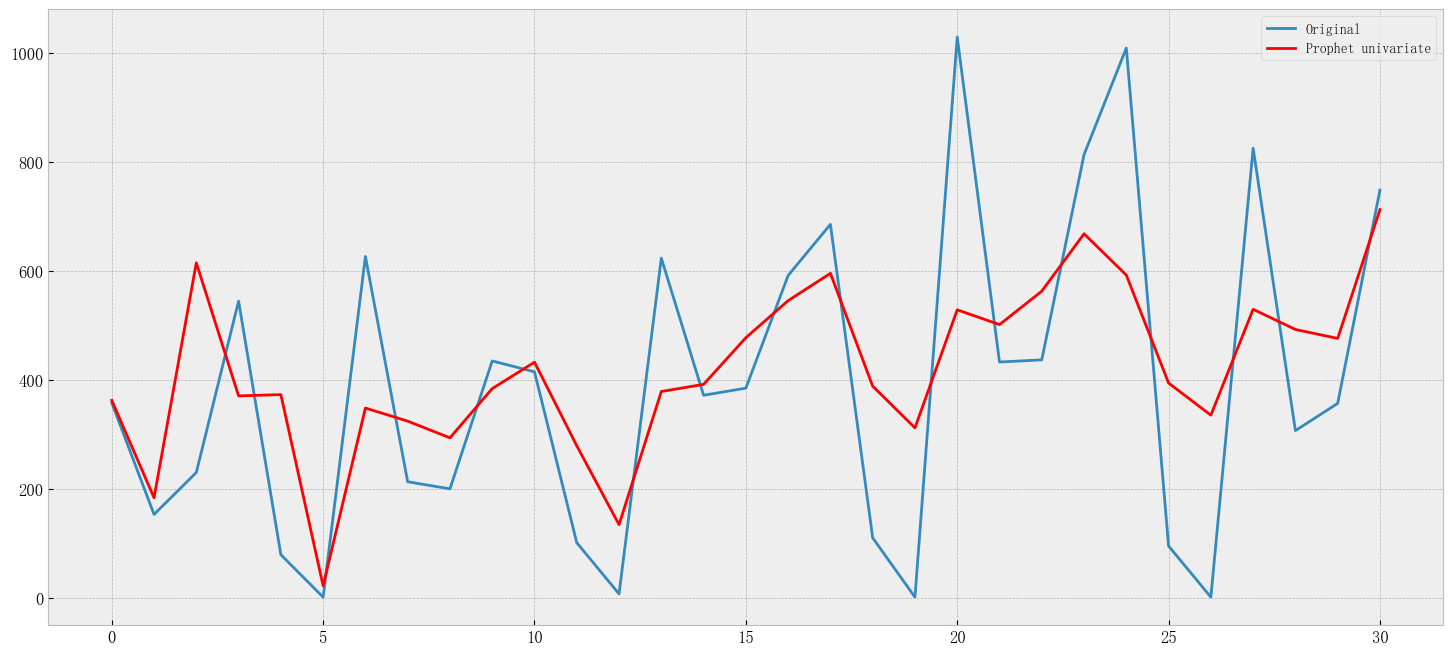

In [50]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet univariate')
plt.legend()

## Multivariate time series forecasting

In [130]:
# ADD time features to our model
def create_time_features(df, target=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = pd.to_datetime(df.index)
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    # df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['sin_day'] = np.sin(df['dayofyear'])
    df['cos_day'] = np.cos(df['dayofyear'])
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.isocalendar().week
    X = df.drop(['date'], axis=1)
    if target:
        y = df[target]
        X = X.drop([target], axis=1)
        return X, y

    return X

In [131]:
X_train_df, y_train = create_time_features(
    df_training, target='离职人数')
X_test_df, y_test = create_time_features(df_test, target='离职人数')
# scaler = StandardScaler()
# scaler.fit(X_train_df)  # No cheating, never scale on the training+test!
# X_train = scaler.transform(X_train_df)
# X_test = scaler.transform(X_test_df)

# X_train_df = pd.DataFrame(X_train_df, columns=X_train_df.columns)
# X_test_df = pd.DataFrame(X_test_df, columns=X_test_df.columns)

### Linear models

#### Bayesian regression

In [53]:
reg = linear_model.BayesianRidge()
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['BayesianRidge'] = evaluate(df_test["离职人数"], yhat)
predictionsDict['BayesianRidge'] = yhat

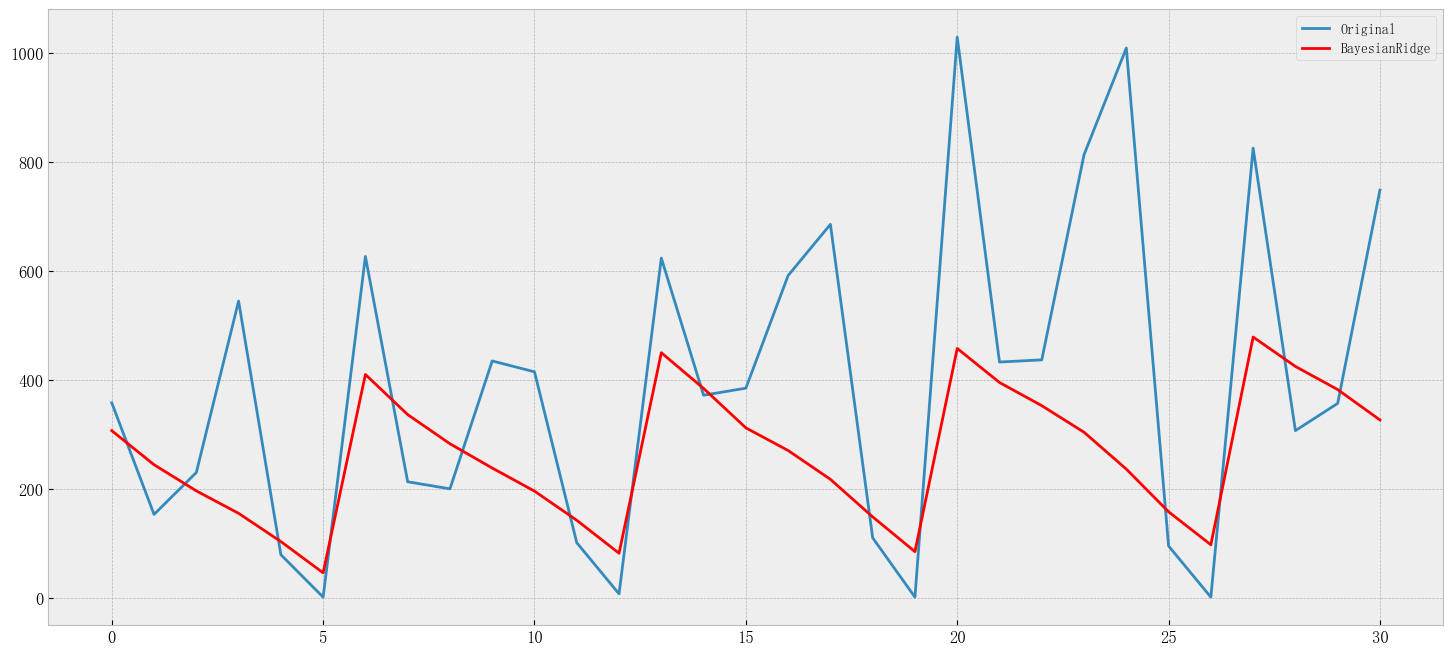

In [54]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat, color='red', label='BayesianRidge')
plt.legend()

#### Lasso

In [55]:
reg = linear_model.Lasso(alpha=0.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Lasso'] = evaluate(df_test["离职人数"], yhat)
predictionsDict['Lasso'] = yhat

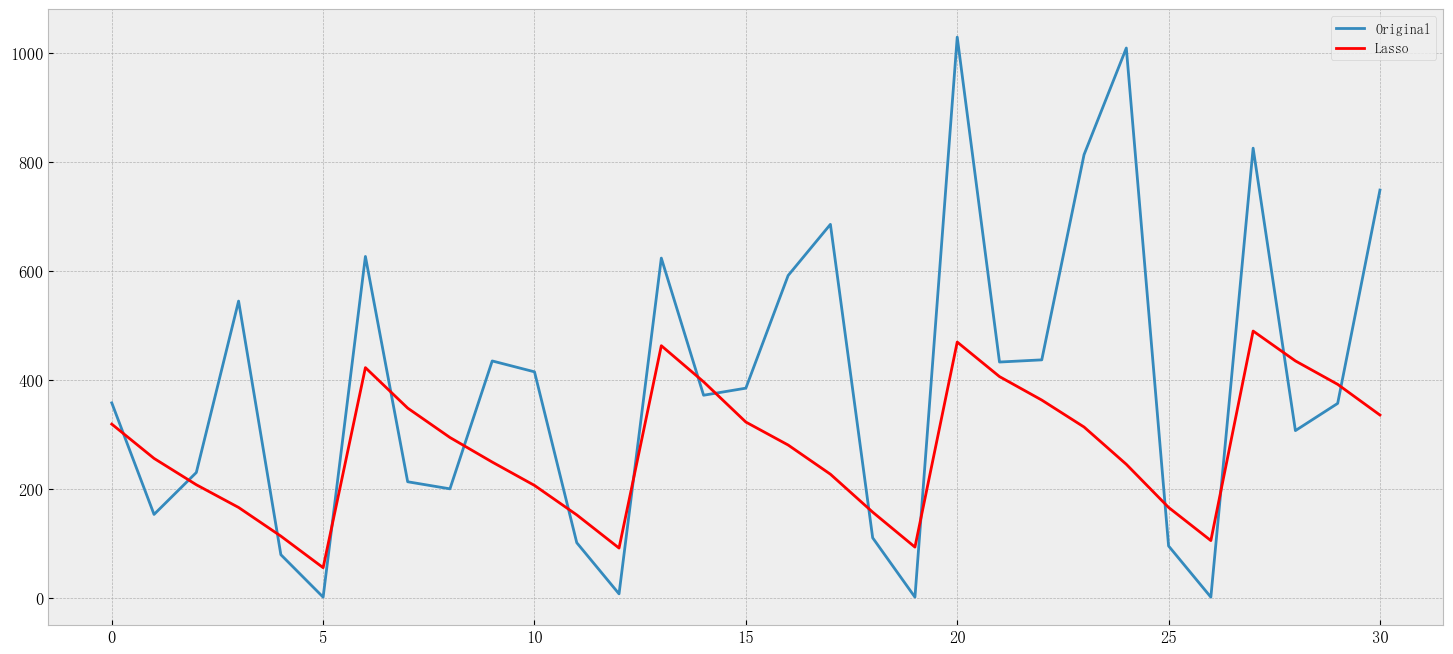

In [56]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat, color='red', label='Lasso')
plt.legend()

### Tree models

#### Randomforest

In [57]:
reg = RandomForestRegressor(max_depth=4, random_state=0)
reg.fit(X_train_df, y_train)
yhat = reg.predict(X_test)
resultsDict['Randomforest'] = evaluate(df_test["离职人数"], yhat)
predictionsDict['Randomforest'] = yhat

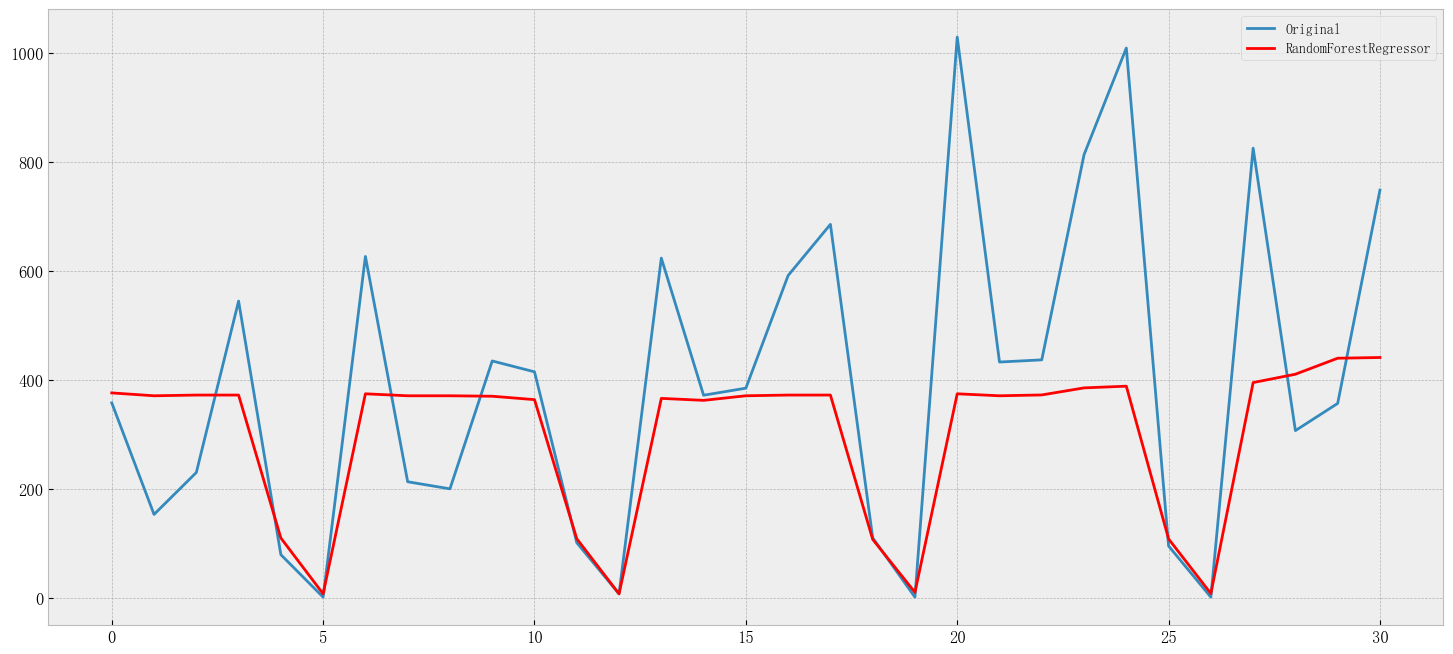

In [58]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat, color='red', label='RandomForestRegressor')
plt.legend()

#### XGBoost

In [117]:
reg = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=1000)
reg.fit(X_train_df, y_train, verbose=False)  # Change verbose to True if you want to see it train
yhat = reg.predict(X_test_df)
yhat = np.round(yhat)
yhat[yhat < 0] = 0
resultsDict['XGBoost'] = evaluate(df_test["离职人数"], yhat)
predictionsDict['XGBoost'] = yhat

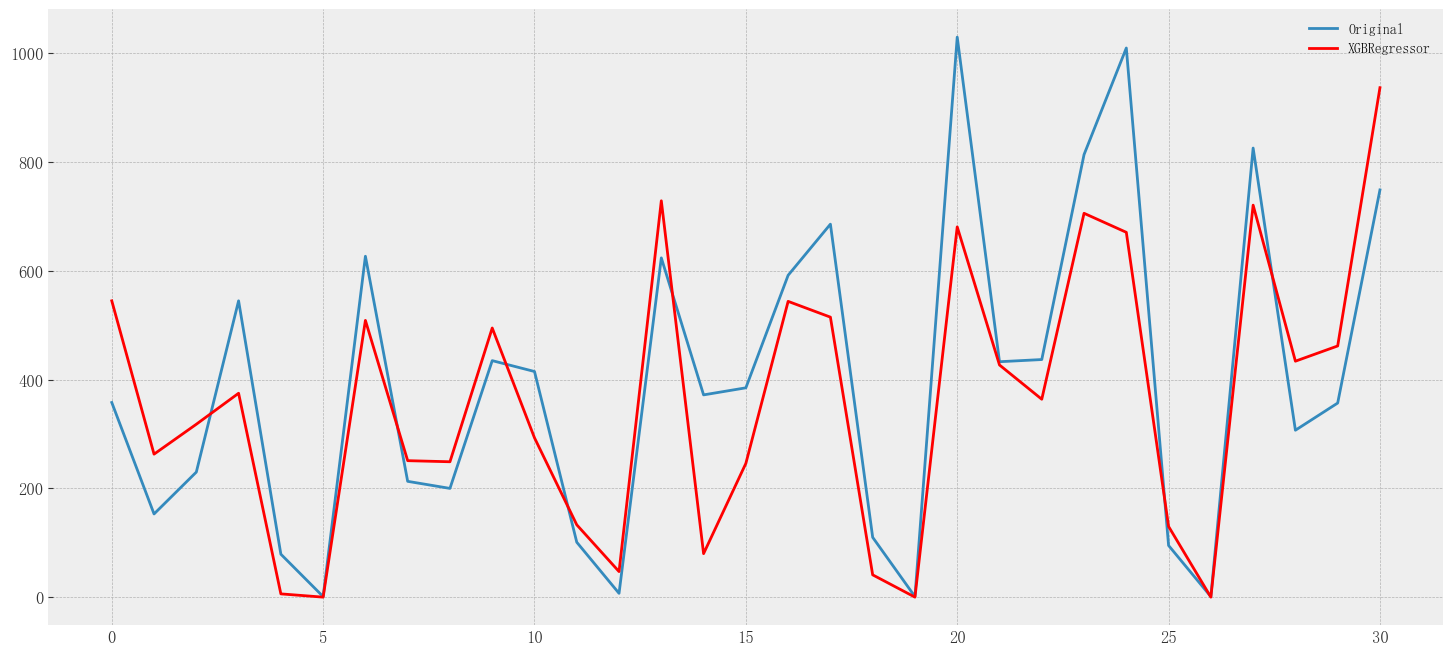

In [118]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat, color='red', label='XGBRegressor')
plt.legend()

In [119]:
resultsDict['XGBoost'] 

{'mae': 108.03225806451613,
 'rmse': 140.0848821020612,
 'mape': 0.5693158954854834,
 'r2': 0.7719326466239502}

#### Lightgbm

In [120]:
lightGBM = lgb.LGBMRegressor()
lightGBM.fit(X_train_df, y_train)
yhat = lightGBM.predict(X_test_df)
yhat = np.round(yhat)
yhat[yhat < 0] = 0
resultsDict['Lightgbm'] = evaluate(df_test["离职人数"], yhat)
predictionsDict['Lightgbm'] = yhat

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1182
[LightGBM] [Info] Number of data points in the train set: 2037, number of used features: 16
[LightGBM] [Info] Start training from score 421.959254


In [121]:
resultsDict['Lightgbm']

{'mae': 90.2258064516129,
 'rmse': 123.94002191486842,
 'mape': 5.958636652488753,
 'r2': 0.8214730760402409}

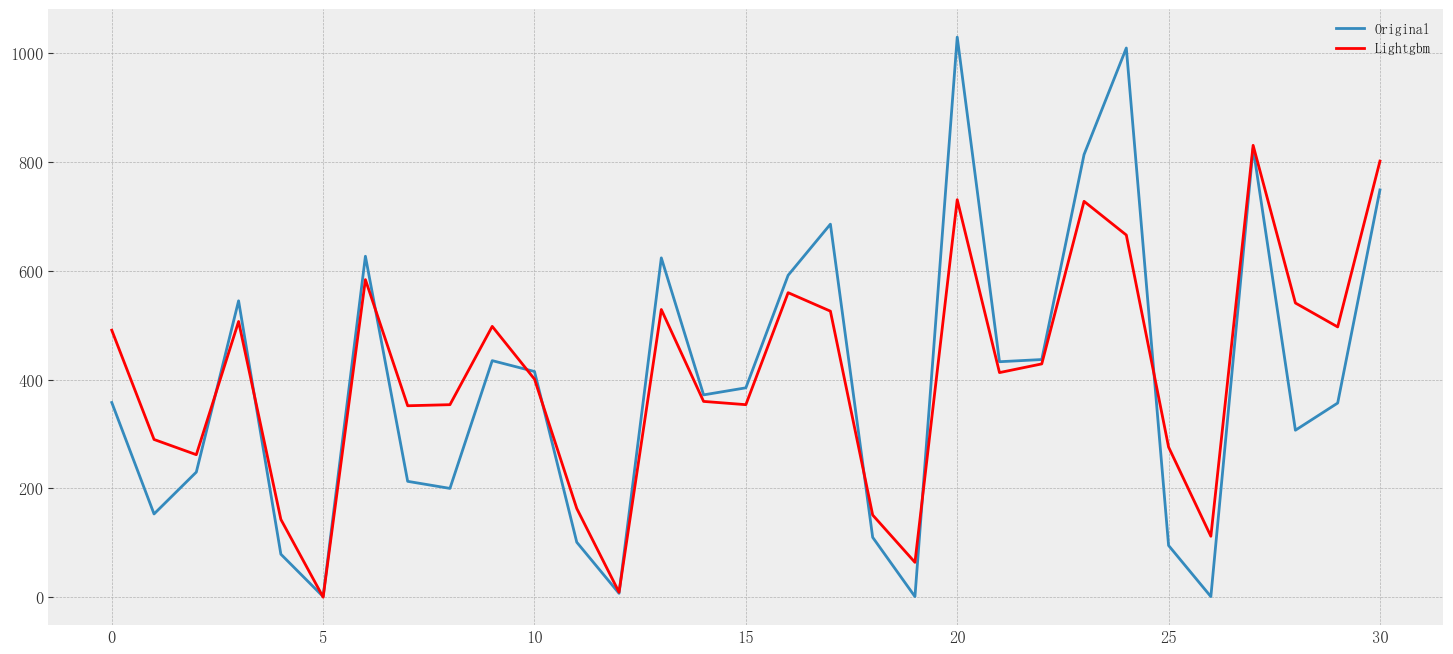

In [122]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat, color='red', label='Lightgbm')
plt.legend()

Text(0.5, 1.0, '每天的预测值与真实值之间的差值')

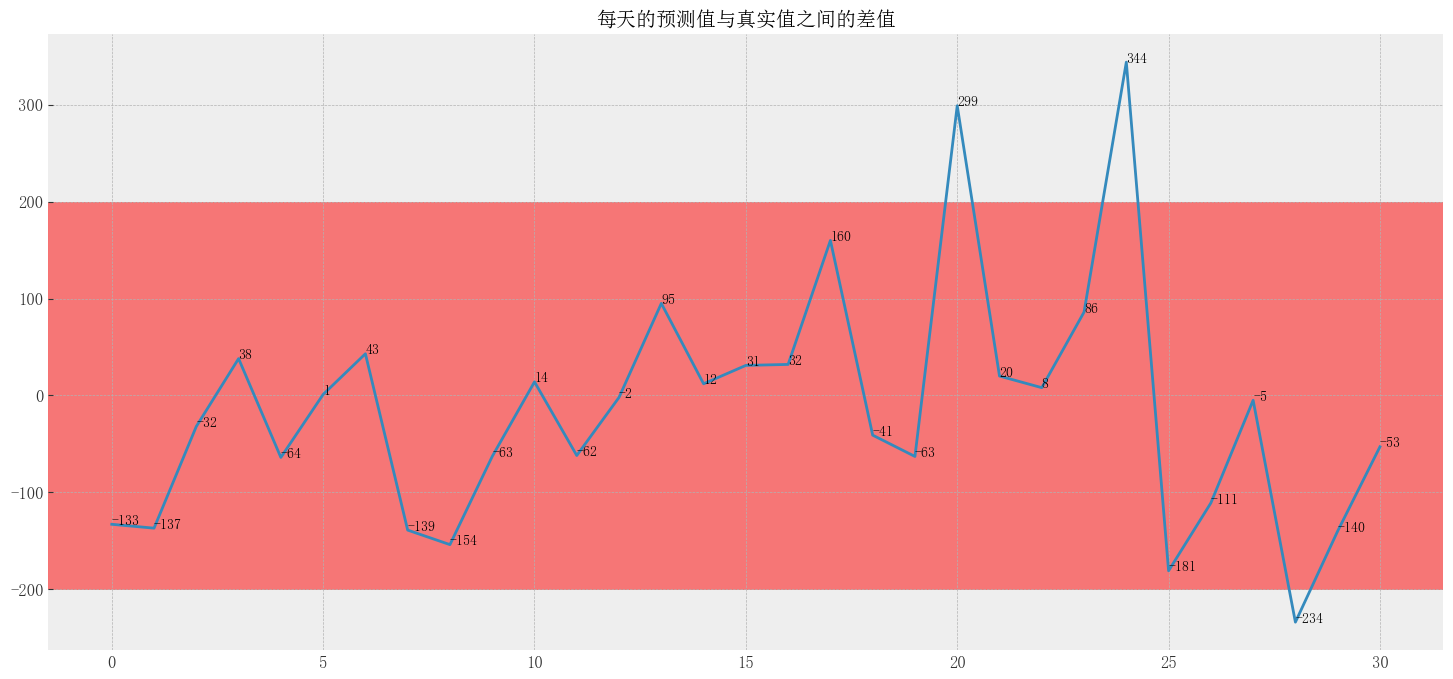

In [123]:
residuals = df_test["离职人数"].values - predictionsDict["Lightgbm"]
plt.plot(residuals)
# plt.axhline(y = 200,color = "red")
# plt.axhline(y = -200,color = "red")
for i,v in  enumerate(residuals):
    plt.text(i,v,int(v))
plt.axhspan(-200,200,alpha = 0.5,color = "red")
plt.title("每天的预测值与真实值之间的差值")

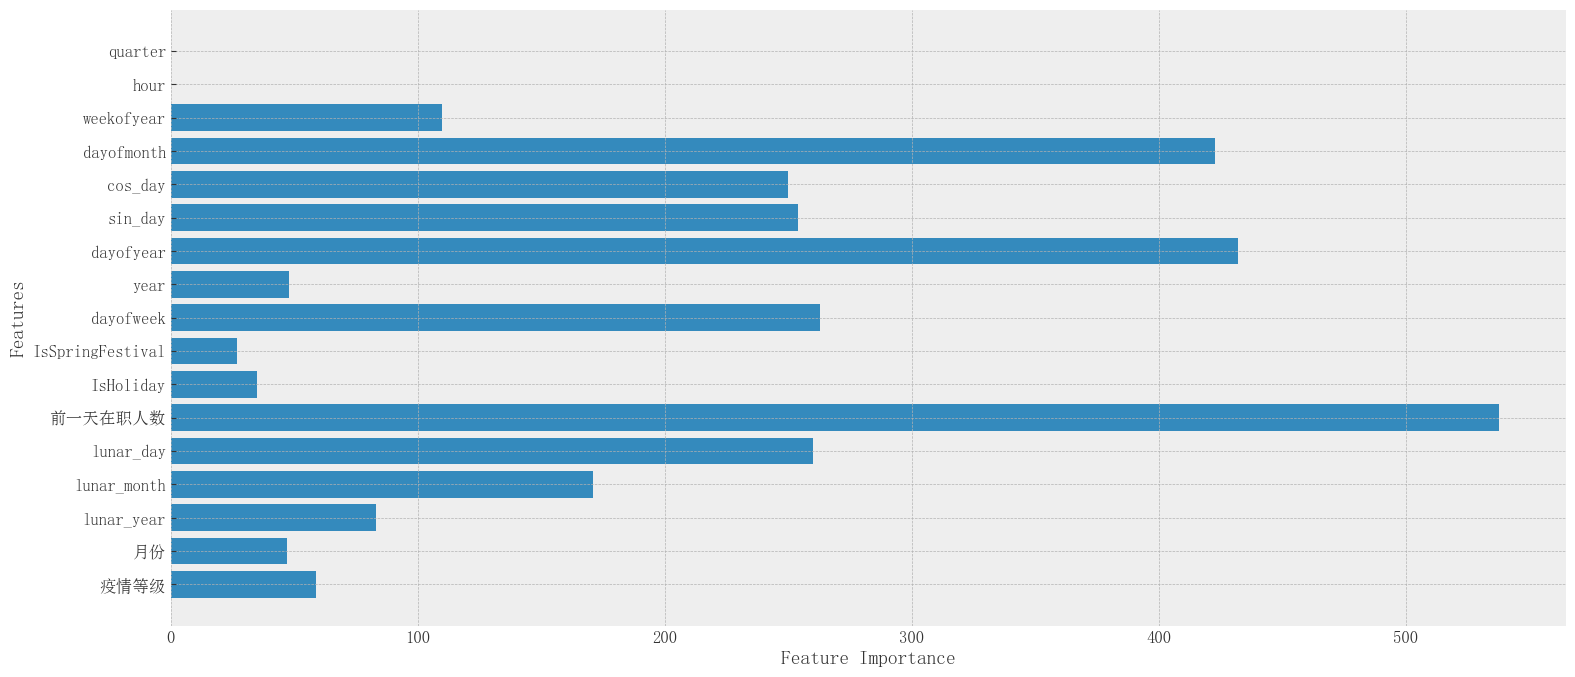

In [124]:


# 提取特征重要性
feature_importance = lightGBM.feature_importances_

# 获取特征名称
feature_names = X_train_df.columns

# 绘制特征重要性条形图
plt.barh(feature_names, feature_importance)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.show()

#####  xgboost + lightgbm

In [125]:
t = (predictionsDict['Lightgbm']*0.5 + predictionsDict['XGBoost']*0.5)
evaluate(df_test["离职人数"], t)


{'mae': 92.45161290322581,
 'rmse': 122.28654872879518,
 'mape': 3.1561972187189538,
 'r2': 0.826204726534883}

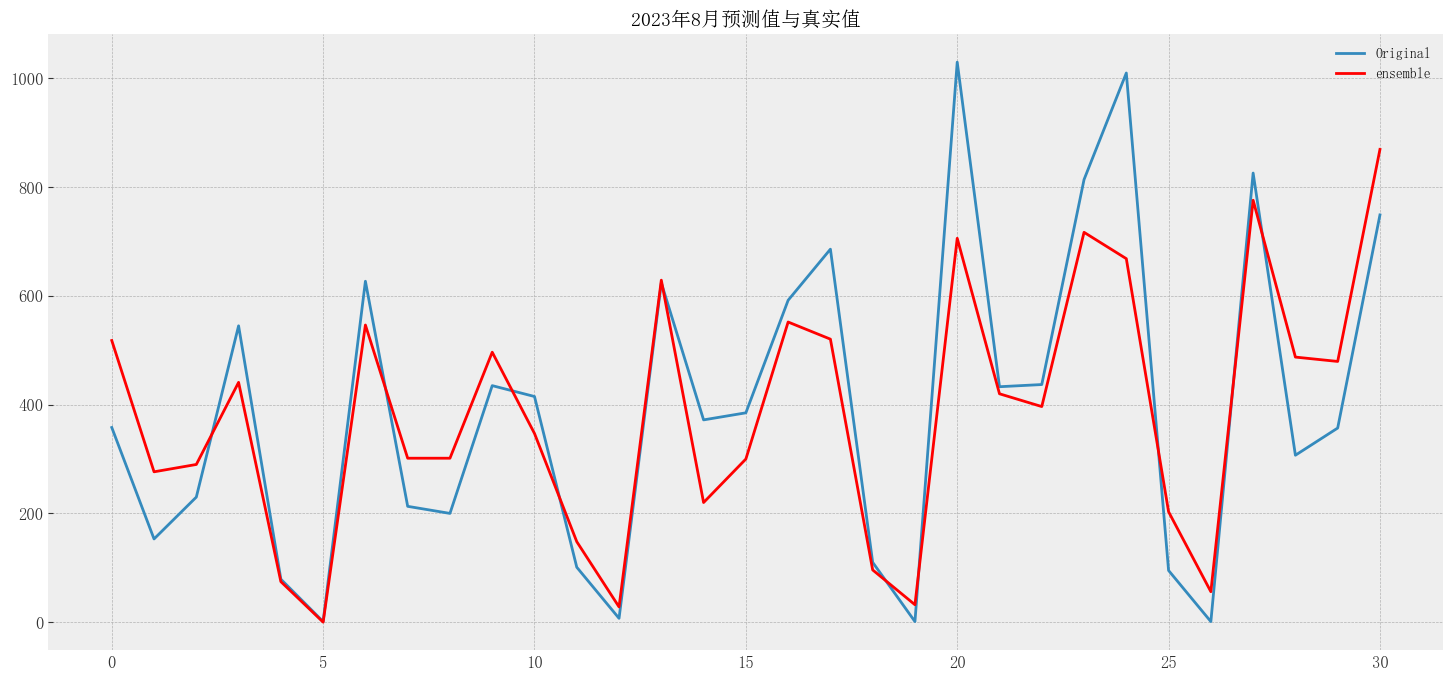

In [126]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(t, color='red', label='ensemble')
# plt.plot(predictionsDict["Lightgbm"], color="yellow", label='l')
# plt.plot(predictionsDict["XGBoost"], color="orange", label='x')
plt.title("2023年8月预测值与真实值")
plt.legend()

Text(0.5, 1.0, '每天的预测值与真实值之间的差值')

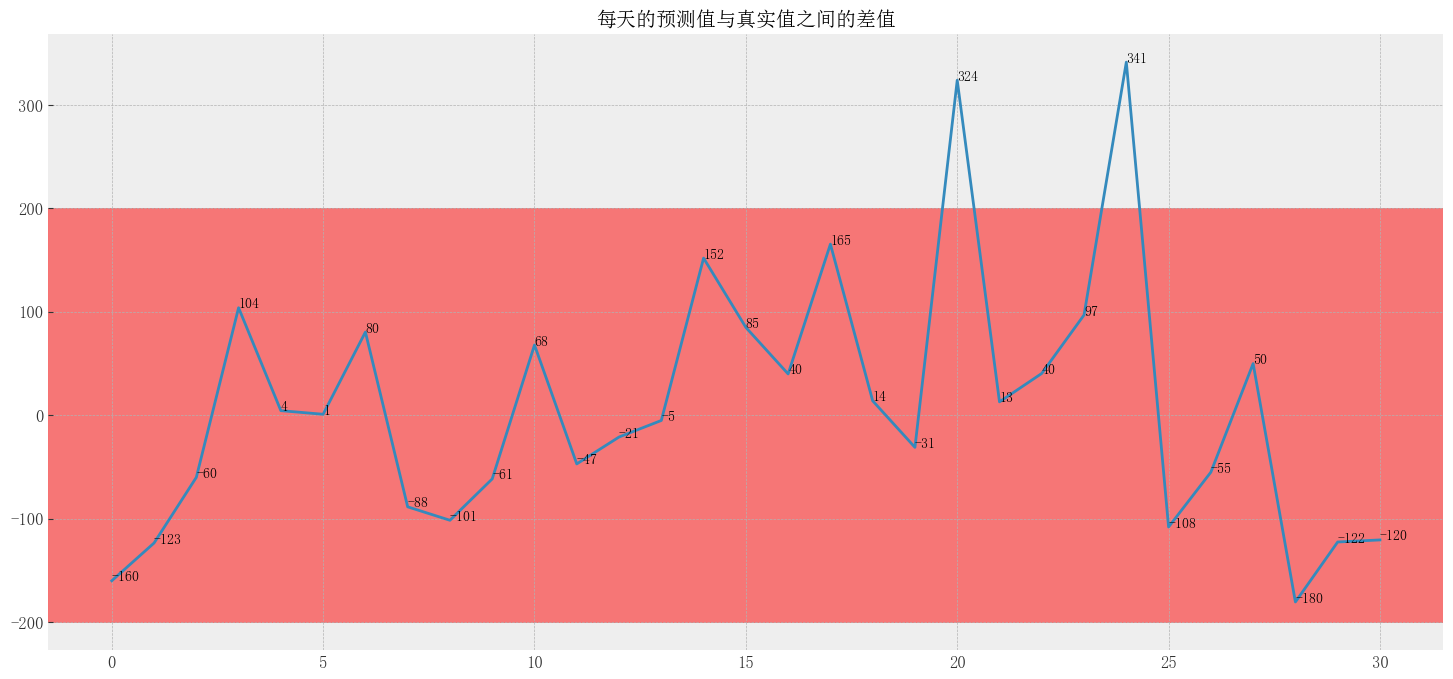

In [127]:
residuals = df_test["离职人数"].values - t
plt.plot(residuals)
# plt.axhline(y = 200,color = "red")
# plt.axhline(y = -200,color = "red")
for i,v in  enumerate(residuals):
    plt.text(i,v,int(v))
plt.axhspan(-200,200,alpha = 0.5,color = "red")
plt.title("每天的预测值与真实值之间的差值")

### Support vector machines

In [69]:
reg = svm.SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF'] = evaluate(df_test["离职人数"], yhat)
predictionsDict['SVM RBF'] = yhat

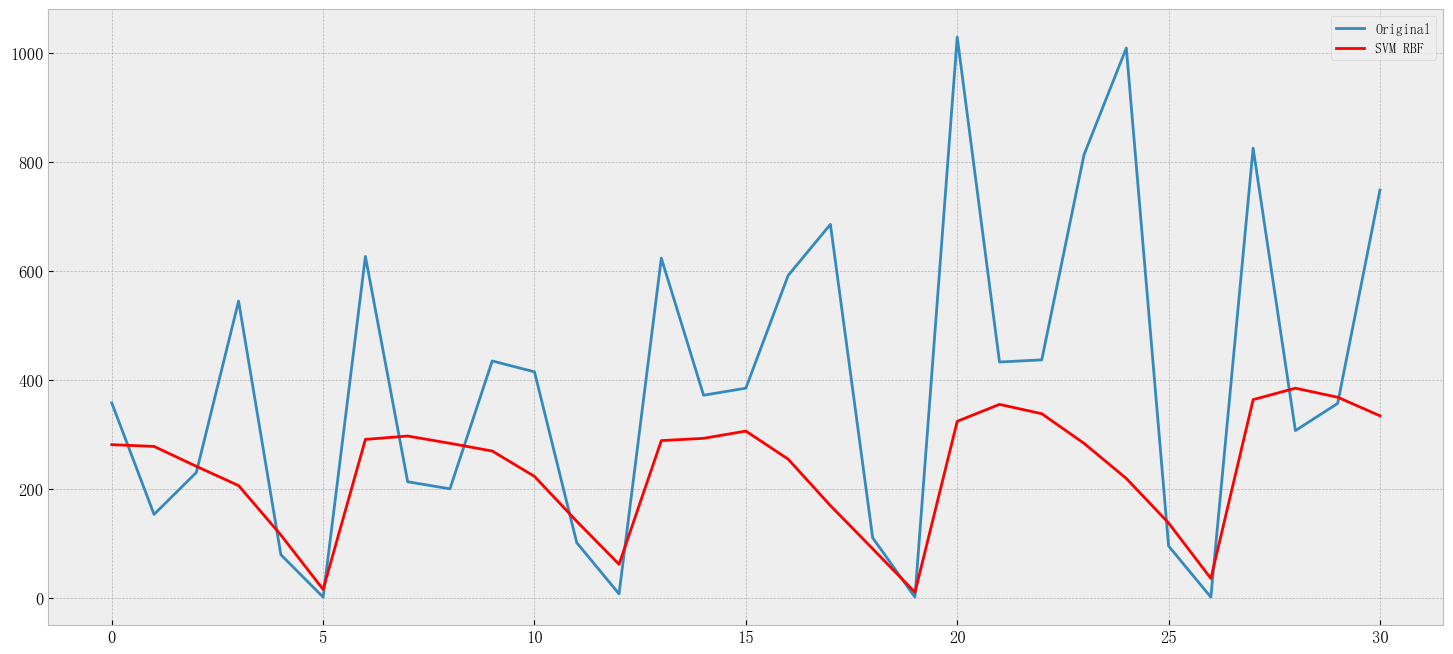

In [70]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat, color='red', label='SVM RBF')
plt.legend()

### Nearest neighbors

In [71]:
reg = KNeighborsRegressor(n_neighbors=6)
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['Kneighbors'] = evaluate(df_test["离职人数"], yhat)
predictionsDict['Kneighbors'] = yhat

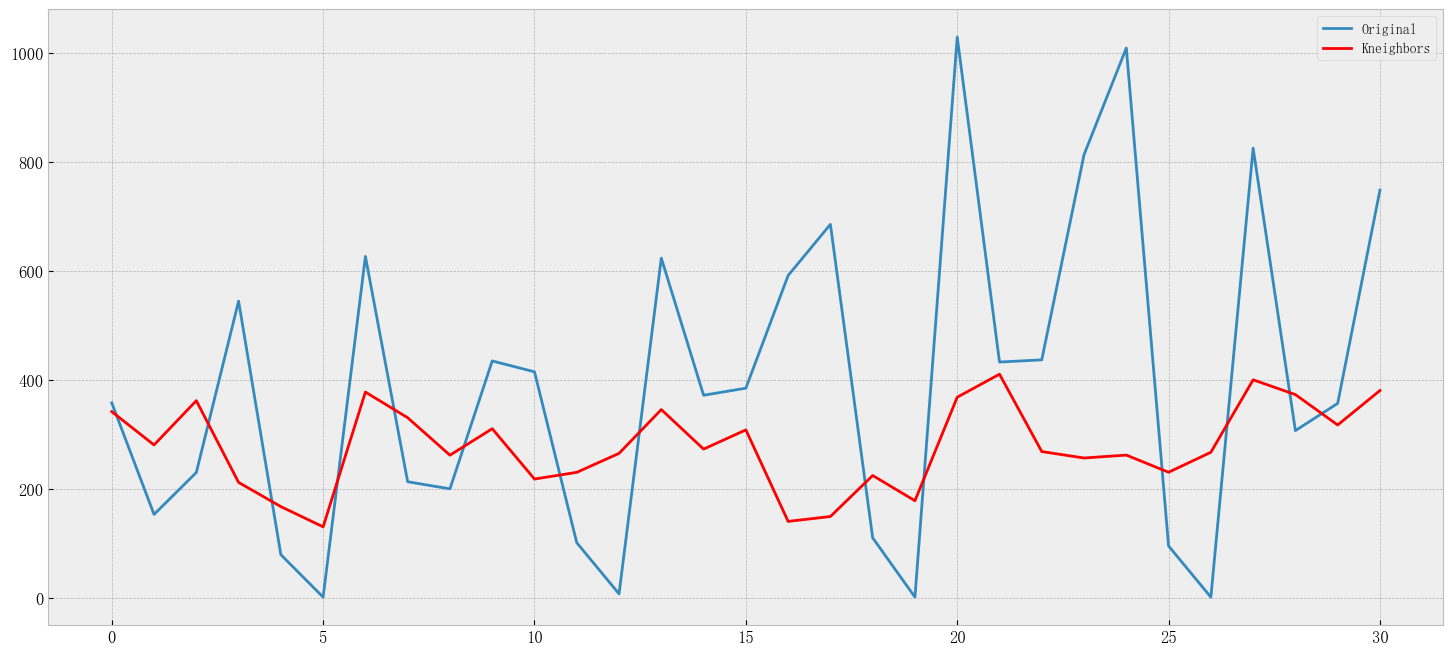

In [72]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat, color='red', label='Kneighbors')
plt.legend()

### Prophet multivariate

In [73]:
prophet = Prophet(
    growth='linear',
    seasonality_mode='multiplicative',
    daily_seasonality=True,
).add_country_holidays(country_name='China')


for col in prophet_training.columns:
    if col not in ["ds", "y"]:
        prophet.add_regressor(col)

In [74]:
prophet.fit(prophet_training)
yhat = prophet.predict(prophet_test)
resultsDict['Prophet multivariate'] = evaluate(y_test, yhat.yhat.values)
predictionsDict['Prophet multivariate'] = yhat.yhat.values

15:51:05 - cmdstanpy - INFO - Chain [1] start processing
15:51:06 - cmdstanpy - INFO - Chain [1] done processing


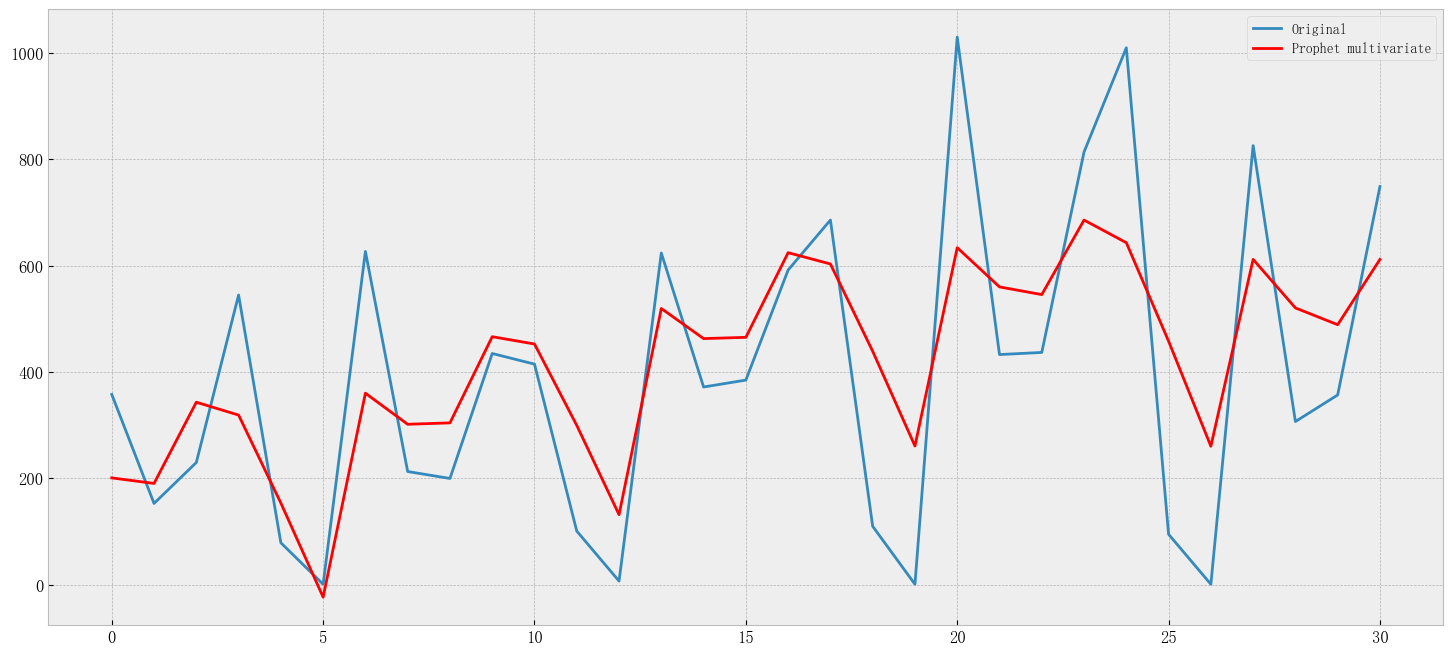

In [75]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat.yhat, color='red', label='Prophet multivariate')
plt.legend()

## Deeplearning:dart框架

### DLinear

In [76]:
from darts import TimeSeries
from darts.models import DLinearModel
y_train.index = pd.to_datetime(y_train.index)
y_test.index = pd.to_datetime(y_test.index)
X_train_df.index= y_train.index
X_test_df.index = y_test.index

# Create a TimeSeries, specifying the time and value columns
X_train_series = TimeSeries.from_dataframe(X_train_df)
X_test_series = TimeSeries.from_dataframe(X_test_df)
y_train_series = TimeSeries.from_series(y_train)
y_test_series = TimeSeries.from_series(y_test)
model = DLinearModel(
    input_chunk_length=365,
    output_chunk_length=30,
    n_epochs=50,
    # randam_state=2023,ran
)
model.fit(y_train_series, past_covariates = X_train_series,future_covariates=X_train_series.append(X_test_series))
pred = model.predict(30)

# Set aside the last 31 months as a validation series
# train, val = series[:-31], series[-31:]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type             | Params
-----------------------------------------------------
0 | criterion       | MSELoss          | 0     
1 | train_metrics   | MetricCollection | 0     
2 | val_metrics     | MetricCollection | 0     
3 | decomposition   | _SeriesDecomp    | 0     
4 | linear_seasonal | Linear           | 295 K 
5 | linear_trend    | Linear           | 295 K 
6 | linear_fut_cov  | Linear           | 14    
-----------------------------------------------------
591 K     Trainable params
0         Non-trainable params
591 K     Total params
2.365     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Predicting: 0it [00:00, ?it/s]

In [77]:
resultsDict['DLinear'] = evaluate(df_test["离职人数"][:-1], pred.values)
predictionsDict['DLinear'] = pred.values

Unable to compute metric mae: unsupported operand type(s) for -: 'float' and 'method'
Unable to compute metric rmse: unsupported operand type(s) for -: 'float' and 'method'
Unable to compute metric mape: unsupported operand type(s) for -: 'float' and 'method'
Unable to compute metric r2: The 'y_pred' parameter of r2_score must be an array-like. Got <bound method TimeSeries.values of <TimeSeries (DataArray) (time: 30, component: 1, sample: 1)>
array([[[332.03854774]],

       [[267.4021463 ]],

       [[470.36839679]],

       [[406.20878318]],

       [[186.02229714]],

       [[ 99.3039214 ]],

       [[788.9928325 ]],

       [[220.05062026]],

       [[367.28949219]],

       [[702.37692118]],

...

       [[584.65110231]],

       [[690.69153772]],

       [[569.82714092]],

       [[680.37866793]],

       [[987.61766697]],

       [[372.55801562]],

       [[226.42862639]],

       [[962.53771872]],

       [[600.2557326 ]],

       [[607.5582867 ]]])
Coordinates:
  * time       

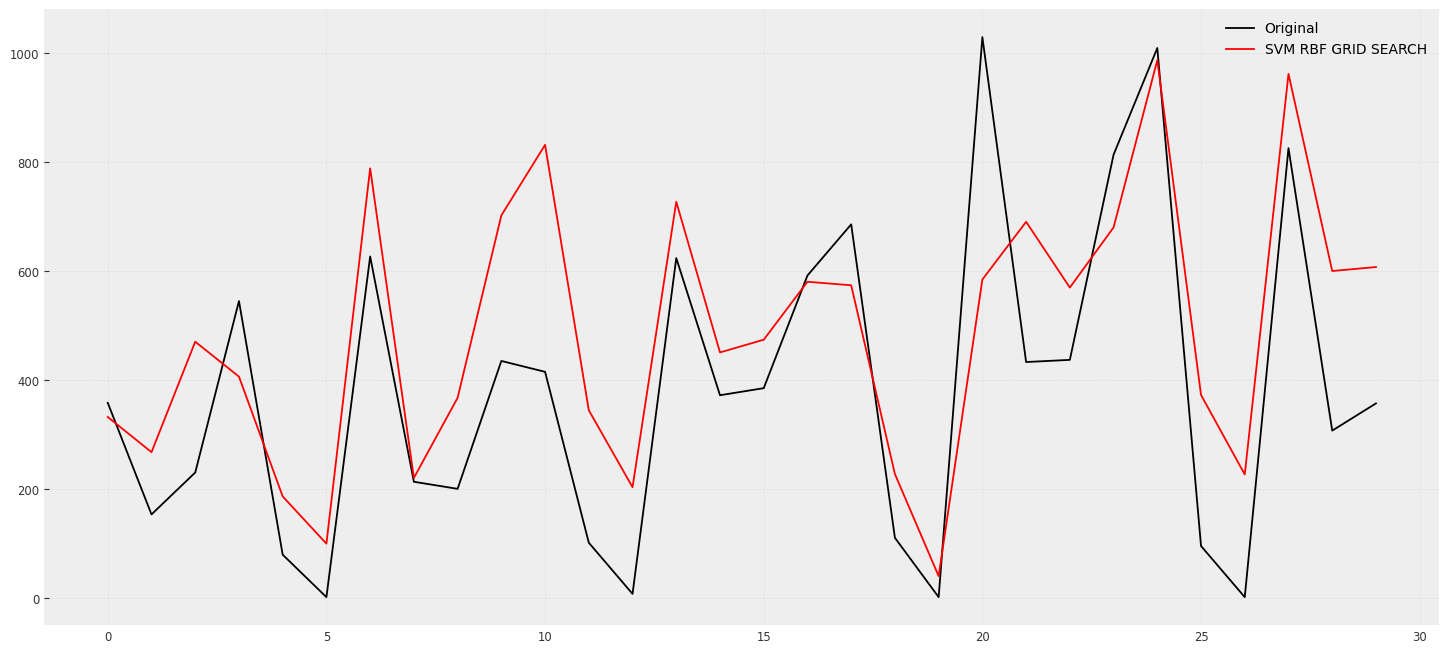

In [78]:
plt.plot(df_test["离职人数"].values[:-1], label='Original')
plt.plot(pred.values(), color='red', label='SVM RBF GRID SEARCH')
plt.legend()

## Hyperparameter optimization

### Grid search - SVM

In [79]:
reg = GridSearchCV(svm.SVR(kernel='rbf', gamma=0.1),
                   param_grid={"C": [1e0, 1e1, 1e2, 1e3],
                               "gamma": np.logspace(-2, 2, 5)})
reg.fit(X_train, y_train)
yhat = reg.predict(X_test)
resultsDict['SVM RBF GRID SEARCH'] = evaluate(df_test["离职人数"], yhat)
predictionsDict['SVM RBF GRID SEARCH'] = yhat

In [80]:
increase = 1 - (resultsDict['SVM RBF GRID SEARCH']
                ['rmse']/resultsDict['SVM RBF']['rmse'])
print(
    f"Grid search Tunned SVM is {increase*100}% better than the SVM with default parameters")

Grid search Tunned SVM is -4.440892098500626e-14% better than the SVM with default parameters


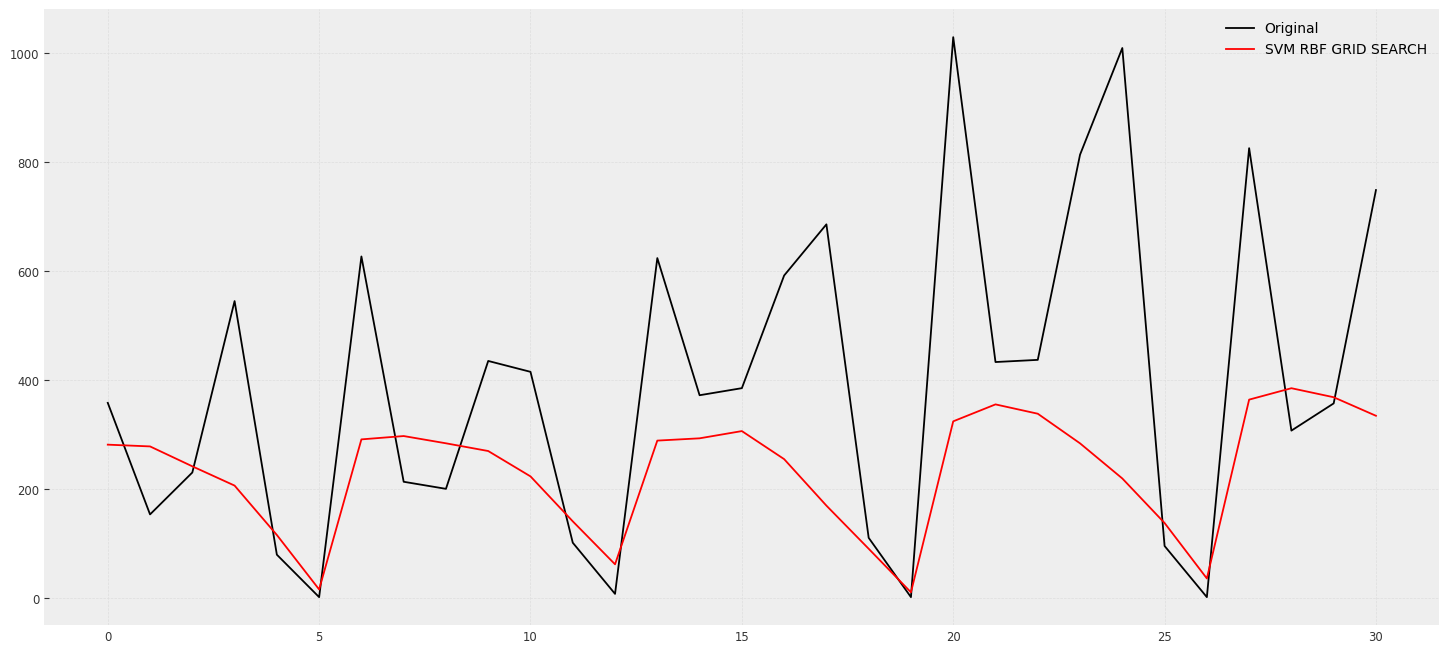

In [81]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat, color='red', label='SVM RBF GRID SEARCH')
plt.legend()

### Bayesian processes - Xgboost

In [82]:
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction

# 定义高斯过程参数
gp_params = {'alpha': 1e-5}

# 定义收益函数
# utility = UtilityFunction(kind="ei", kappa=2.5, xi=0.0)

def rms(y_actual, y_predicted):
    return sqrt(mean_squared_error(y_actual, y_predicted))


my_scorer = make_scorer(rms, greater_is_better=False)
pbounds = {
    'n_estimators': (100, 10000),
    'max_depth': (3, 15),
    'min_samples_leaf': (1, 4),
    'min_samples_split': (2, 10),
}


def rf_hyper_param(n_estimators,
                   max_depth,
                   min_samples_leaf,
                   min_samples_split):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = RandomForestRegressor(n_estimators=n_estimators,
                                max_depth=int(max_depth),
                                min_samples_leaf=int(min_samples_leaf),
                                min_samples_split=int(min_samples_split),
                                n_jobs=1)

    return -np.mean(cross_val_score(clf, X_train, y_train, cv=3))



optimizer = BayesianOptimization(
    f=rf_hyper_param,
    pbounds=pbounds,
    random_state=1,
)
# 设置高斯过程参数
optimizer.set_gp_params(**gp_params)

optimizer.maximize(
    init_points=3,
    n_iter=20,
)

ModuleNotFoundError: No module named 'bayes_opt'

In [ ]:
params = optimizer.max['params']

# Converting the max_depth and n_estimator values from float to int
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
params['min_samples_leaf'] = int(params['min_samples_leaf'])
params['min_samples_split'] = int(params['min_samples_split'])

# Initialize an XGBRegressor with the tuned parameters and fit the training data
tunned_rf = RandomForestRegressor(**params)
# Change verbose to True if you want to see it train
tunned_rf.fit(X_train, y_train)

yhat = tunned_rf.predict(X_test)
resultsDict['Randomforest tunned'] = evaluate(y_test, yhat)

In [ ]:
increase = 1 - (resultsDict['Randomforest tunned']
                ['rmse']/resultsDict['Randomforest']['rmse'])
print(
    f"Bayesian optimized Randomforest is {increase*100}% better than the Randomforest with default parameters")

Bayesian optimized Randomforest is 2.4148051517381086% better than the Randomforest with default parameters


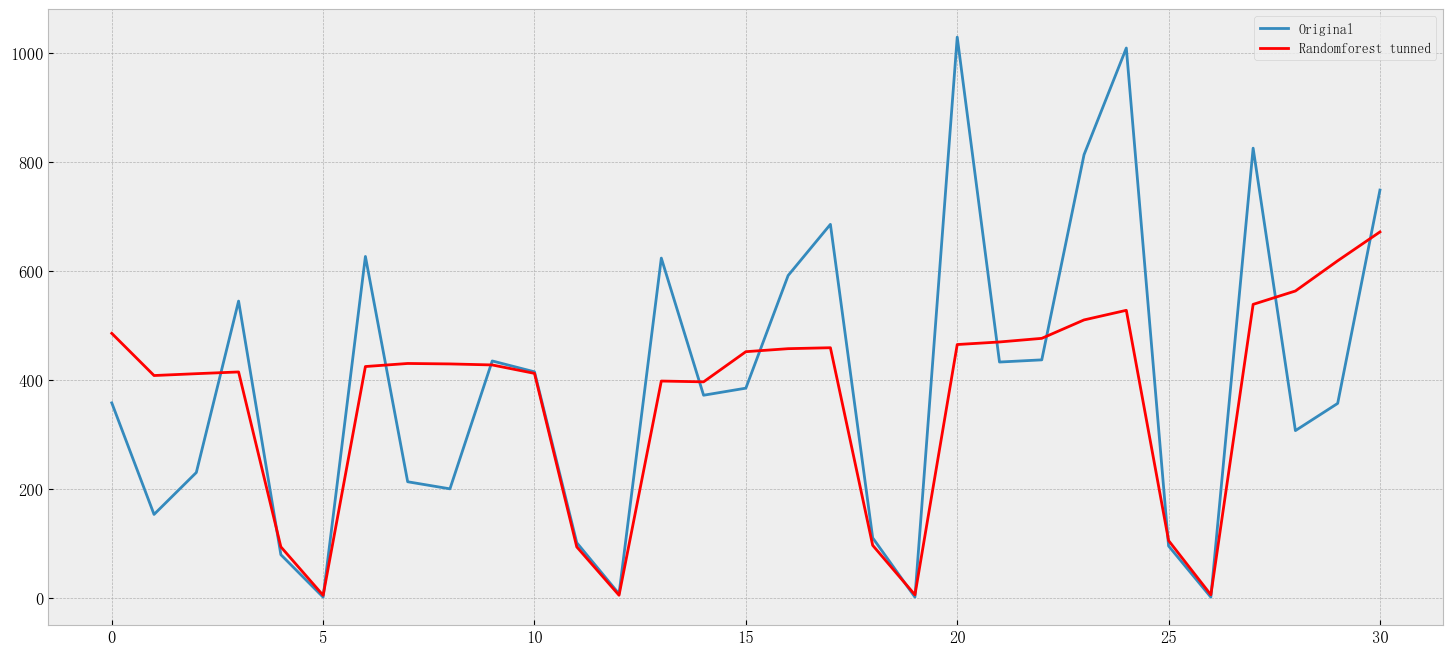

In [ ]:
plt.plot(df_test["离职人数"].values, label='Original')
plt.plot(yhat, color='red', label='Randomforest tunned')
plt.legend()

In [83]:

with open('results/scores.pickle', 'wb') as handle:
    pickle.dump(resultsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('results/predictions.pickle', 'wb') as handle:
    pickle.dump(predictionsDict, handle, protocol=pickle.HIGHEST_PROTOCOL)